# Setting up our Notebook

In [78]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

from copy import deepcopy
import gym


import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline

import numpy as np
import pandas as pd
import gym

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from gym import Env
from gym.spaces import Discrete, Box
from collections import deque
import random
import itertools
import torch.nn.functional as F
import time

# Importing the data

In [79]:
# Importing the data

dfs=['Non-Scaled TA Features 1H for BTC.csv',
    'Non-Scaled TA Features 1H for ETH.csv',
    'Non-Scaled TA Features 1H for LTC.csv']

# Twin Delayed Deep Deterministic Polcy Gradient

## Getting the train/test data

In [80]:
# Defining a function to create PCA matrices

def PCA_creation_train_test(no_components, X_train, X_test):
    
    # Scaling the data with our X_train matrix
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    
    # Fitting the PCA to our X_train matrix
    pca=PCA(n_components=no_components)
    X_train=pca.fit_transform(X_train)

    # Scaling the X_test 
    X_test=scaler.transform(X_test)

    # Transforming the X_test
    X_test=pca.transform(X_test)
    
    return X_train, X_test

In [81]:
# Train and test splitting and scaling

# Choose the coin we are interested in. 0=BTC, 1=ETH, 2=LTC

X=pd.read_csv(dfs[0])

X['Date']=pd.to_datetime(X['Date']) # Setting the index as the Date
X=X.set_index('Date').asfreq('H')

X=X.dropna()
y=X['Percent Change']
X=X.drop('Label', axis=1)
X=X.drop('Percent Change', axis=1)


# Removing the testing data
X_test=X[-4380:] # Getting the last 6 months as the testing data
print(X_test.columns)
y_test=y[-4380:].values

X=X[:-4380] # Getting everything but the first 6 months as the training data
y=y[:-4380]
print(y[0])

Index(['BB_upper 10', 'BB_middle 10', 'BB_lower 10', 'Aroon_down 10',
       'Aroon_up 10', 'Aroonosc 10', 'RSI 10', 'NATR 10', 'BB_upper 12',
       'BB_middle 12',
       ...
       'MACD Signal 18', 'MACD Hist18', 'Med Price', 'Chaikin A/D Line',
       'HT Dom Phase', 'HT Dom Period', 'High', 'Low', 'Close', 'Volume'],
      dtype='object', length=101)
0.1147041620139344


In [82]:
# Image creation function

def image_creation(n_steps, X, y):
    X_images=[]
    y_values=[]
    
    for i in range(n_steps, len(X)):
        img=X[i-n_steps,:]
        img=np.vstack((img, X[i-n_steps+1,:]))
        img=np.vstack((img, X[i-n_steps+2,:]))
        img=np.vstack((img, X[i-n_steps+3,:]))
        img=np.vstack((img, X[i-n_steps+4,:]))
        img=np.vstack((img, X[i-n_steps+5,:]))
        img=np.vstack((img, X[i-n_steps+6,:]))
        img=np.vstack((img, X[i-n_steps+7,:]))
        img=np.vstack((img, X[i-n_steps+8,:]))
        img=np.vstack((img, X[i-n_steps+9,:]))
        img=np.vstack((img, X[i-n_steps+10,:]))
        img=np.vstack((img, X[i-n_steps+11,:]))
        X_images.append(img)
        y_values.append(y[i-n_steps+11])
        
    return X_images, np.array(y_values) # Note, this will not include the very last one.

In [83]:
n_steps=12

# First, we create our PCA matrices from the X and X_test
X, X_test=PCA_creation_train_test(20, X, X_test)
    
# Getting the X and X_test matrices' images
X_train, y_train=image_creation(n_steps, X ,y)
X_test, y_test=image_creation(n_steps, X_test, y_test)

y_train=np.array(y_train)
y_test=np.array(y_test)

# Finalizing the shapes
num_classes = 2
input_shape = (n_steps, len(X[0]), 1)

# Add a dimension at the beginning end to make sure images have shape (1, n_steps, n_features)
# Note this is the OPPOSITE of tensorflow
X_train = np.expand_dims(X_train, 1)
X_test = np.expand_dims(X_test, 1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")
print(y_train)

X_train shape: (26264, 1, 12, 20)
26264 train samples
4368 test samples
[ 0.12799975 -0.04142694  0.22268477 ...  0.01456062 -1.21821058
  0.01243332]


In [84]:
print(y_train)
print(y_test)

[ 0.12799975 -0.04142694  0.22268477 ...  0.01456062 -1.21821058
  0.01243332]
[ 0.29675316 -0.8274389   0.47853097 ...  0.37927447  0.98700007
 -0.01400845]


## Financial Environment

In [85]:
class FinEnv(Env):
    
    # A custom Bitcoin trading environment
    def __init__(self, df, y, initial_balance=1000):
        # Define action space and state size and other custom parameters
        self.df = df
        self.y = y
        self.df_total_steps = len(self.df) # How many steps we can possibly take
        self.initial_balance = initial_balance
        self.current_balance = self.initial_balance # How much we currently have 
        self.current_investment = 0 # In the beginning, we have nothing invested
        self.net_worth = self.initial_balance # How much we have between our investment and our balance
        self.actions_taken=[] # Keeping a log of our actions
        
        # Orders history contains the balance, net_worth, crypto_bought, crypto_sold, crypto_held values for the last lookback_window_size steps
        self.orders_history = deque(maxlen=self.df_total_steps)
        
        # Market history
        self.market_history = deque(maxlen=1)

        # Action space is 1D. Between 0 and 1 is Buy and between -1 and 0 is Sell
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)

        # State size contains the 12 time slices of 
        # 20 PCA data points per time slice plus the current balance and investment added on
        self.observation_space = np.zeros((1,13,20))

    # Reset the state of the environment to an initial state
    def reset(self, env_steps_size=0):
        self.net_worth = self.initial_balance
        self.prev_net_worth = self.initial_balance
        self.current_balance = self.initial_balance # How much we currently have 
        self.current_investment = 0 # In the beginning, we have nothing invested
        self.actions_taken=[] # Keeping a log of our actions
        if env_steps_size > 0: # used for training dataset
            self.start_step = random.randint(0, self.df_total_steps - env_steps_size) # Picks a random step to start from
            self.end_step = self.start_step + env_steps_size # Runs from the randomly chosen step to that step+env_steps we want
        else: # used for testing dataset
            self.start_step = 0
            self.end_step = self.df_total_steps-1
            
        self.current_step = self.start_step

        # Getting the state information
        self.state = self.df[self.current_step]
        self.cb = self.current_balance/1000
        self.ci = self.current_investment/1000 # State is the state of the 
        # market and how much we have as balance and invested. We divide by 1000 to have it on the same scale
        # as the other state information
        self.portfolio = [self.cb, self.ci, self.cb, self.ci, self.cb, self.ci, self.cb, self.ci,
                         self.cb, self.ci, self.cb, self.ci, self.cb, self.ci, self.cb, self.ci,
                         self.cb, self.ci, self.cb, self.ci]
        self.state1 = np.vstack((self.state[0], self.portfolio))
        self.state2 = np.expand_dims(self.state1, axis=0)
        self.state = np.float64(self.state2) # Required to transform the state into a torch tensor
        return self.state

    # Get the data points for the given current_step
    def _next_observation(self):
        
        obs = self.df[self.current_step]
        cb = np.float64(self.current_balance/1000)
        ci = np.float64(self.current_investment/1000) # State is the state of the 
        # market and how much we have as balance and invested. We divide by 1000 to have it on the same scale
        # as the other state information
        portfolio = [cb, ci, cb, ci, cb, ci, cb, ci,
                         cb, ci, cb, ci, cb, ci, cb, ci,
                         cb, ci, cb, ci]
        obs1 = np.vstack((obs[0], portfolio))
        obs2 = np.expand_dims(obs1, axis=0)
        obs = np.float64(obs2) # Required to transform the obs into a torch tensor
        return obs
    
    # Execute one time step within the environment
    def step(self, action):
        
#         print('Action Pre-Clip',action)
        action = np.clip(action, -1.0, 1.0)
#         print('Action Post-Clip', action)
        
        # Percent Change
        self.percent_change = self.y[self.current_step]
#         print('Percent Change ', self.percent_change)
        
        # Investment and balance
        if action >= 0: # If our action is to buy, we will invest the percent dictated by the action 
            # and add it to our current investment
            
#             print('Investment before agent acts', self.current_investment)
#             print('Balance before agent acts', self.current_balance)
#             print('Net Worth before agent acts', self.net_worth)
            
            # Decreasing our balance and increasing our investment
            self.current_investment = self.current_investment + (action)*self.current_balance # Adding to our investment
            self.actions_taken.append('Bought '+str(action*self.current_balance)) # Logging our buy before
            # we change our balance to reflect that we bought
            self.current_balance = self.current_balance - (action)*self.current_balance # Removing that same amount from our balance
    
#             print('Investment after agent acts', self.current_investment)
#             print('Balance after agent acts', self.current_balance)
#             print('Net Worth after agent acts', self.net_worth)
            
            # Now, the market will act and we will update our investment and overall net worth
            self.current_investment = (1 + self.percent_change/100)*self.current_investment
            self.net_worth = self.current_investment + self.current_balance # Our net worth
            # will be our current balance plus our investment, which will change during this time slice by
            # the percent change
            
#             print('Investment after market acts', self.current_investment)
#             print('Balance after market acts', self.current_balance)
#             print('Net Worth after market acts', self.net_worth)
        
        elif action < 0: # If our action is to sell, we will sell the percent dictated by the action of our investment
            # and add it to our current balance
            
#             print('Investment before agent acts', self.current_investment)
#             print('Balance before agent acts', self.current_balance)
#             print('Net Worth before agent acts', self.net_worth)
            
            # Decreasing our investment and increasing our balance
            self.current_balance = self.current_balance + np.abs(action)*self.current_investment # Adding to our balance
            self.actions_taken.append('Sold '+str(action*self.current_investment)) # Logging our sell before
            # we change the investment
            self.current_investment = self.current_investment - np.abs(action)*self.current_investment # Removing that same amount from our investment
            
#             print('Investment after agent acts', self.current_investment)
#             print('Balance after agent acts', self.current_balance)
#             print('Net Worth after agent acts', self.net_worth)
            
            
            # Now, the market will act and we will update our investment and overall net worth
            self.current_investment = (1 + self.percent_change/100)*self.current_investment
            self.net_worth = self.current_investment + self.current_balance # Our net worth
            # will be our current balance plus our investment, which will change during this time slice by
            # the percent change
            
#             print('Investment after market acts', self.current_investment)
#             print('Balance after market acts', self.current_balance)
#             print('Net Worth after market acts', self.net_worth)
#         print('\n')

        # Reward        
        reward = self.net_worth-self.prev_net_worth # Our reward is the change in our net worth
        
        # Updating our prev_net_worth
        self.prev_net_worth = self.net_worth # Updating our prev_net_worth for the next time step

        self.orders_history.append([self.net_worth]) # Adding our net worth to our orders_history
        
        # # Leave the market if we have lost half our money
        # if self.net_worth <= self.initial_balance/2:
        #     done = True
        # else:
        #     done = False
            
        # Stepping into the next state
        if self.current_step == self.end_step:
            # print('We are done stepping', self.current_step)
            obs=[]
            done = True
        else:    
            self.current_step += 1    
            obs = self._next_observation() # Moves us to the next observation
            done = False
            
        # Set net worths as info so we can retrieve it at the end
        info = self.orders_history

        return obs, reward, done, info

    # render environment
    def render(self, mode='human'): # 'mode=human' is required for the Keras-RL package
        print(f'Step: {self.current_step}, Net Worth: {self.net_worth}')

## Random Games

In [86]:
def Random_games(env, episodes = 50, batch_size=1000):
    for episode in range(episodes): # Runs through however many number of training episodes
        state = env.reset(env_steps_size = batch_size) # Sets the env_step_size to the batch size

        while True:
            # env.render()

            action = np.random.uniform(-1, 1)
            # print('Action ',action)

            state, reward, done, info= env.step(action)
            # print('Reward', reward)
            if done == True:
                print(info[-1])
                print(len(info))
                break

In [87]:
df=X_train
y=y_train
train_env = FinEnv(df, y)

Random_games(train_env, episodes = 1, batch_size=0)

[1803.1648089120592]
26264


## Build Policy Network (Actor)

In [88]:
class MLPActor(nn.Module):
    def __init__(self, state_dim, act_dim, act_limit):
        super().__init__()
        self.act_limit = act_limit
        
        
        # Conv and Pooling Layer
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))
        
        self.actor = nn.Linear(512, act_dim)
    
    def forward(self, s):
        # Because it keeps adding a dimension, we need to be careful that we always know how many
        # dimensions we are feeding to our CNN
        if len(s.shape) == 3:
            state = torch.unsqueeze(s, 1)
        if len(s.shape) == 4:
            state = s
        # Conv and Pool Layer
        x = self.conv_network(state)
        # MLP Layer
        x = self.fc_network(x)
        # Getting our Action
        x = self.actor(x)
        # Getting our Action in the form we want
        x = torch.tanh(x)  # to output in range(-1,1)
        x = self.act_limit * x
        return x


## Build Q-network Network (Critic)

In [89]:
class MLPQFunction(nn.Module):
    def __init__(self, state_dim, act_dim):
        super().__init__()
        
        # Conv and Pooling Layer
        self.conv_network = nn.Sequential()
        self.conv_network.add_module('conv', nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=0)) # 'Valid' padding
        self.conv_network.add_module('tanh', nn.Tanh())
        self.conv_network.add_module('avg_pool', nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.conv_network.add_module('flatten', nn.Flatten())

        self.fc_network = nn.Sequential()
        self.fc_network.add_module('linear1', nn.Linear(2880, 512))
        self.fc_network.add_module('tanh1', nn.Tanh())
        self.fc_network.add_module('Dropout1', nn.Dropout(0.6))
        self.fc_network.add_module('linear2', nn.Linear(512, 512))
        self.fc_network.add_module('tanh2', nn.Tanh())
        self.fc_network.add_module('Dropout2', nn.Dropout(0.6))
        
        self.critic = nn.Linear(513, 1) # We added the Action at the end
    
    def forward(self, s, a):

        # Conv and Pool Layer
        y = self.conv_network(s)
        # MLP Layer
        y = self.fc_network(y)
        # Adding our Action
        y = torch.cat([y,a], dim=-1)
        # Getting our critique
        q = self.critic(y)
        return torch.squeeze(q, -1)
        

## Combine Actor and Critic into a single model for T3D

In [90]:
class MLPActorCritic(nn.Module):
    def __init__(self, observation_space, action_space):
        super().__init__()
        self.state_dim = len(observation_space)
        self.act_dim = action_space.shape[0]
        self.act_limit = action_space.high[0]
        
        #build Q and policy functions
        self.q1 = MLPQFunction(self.state_dim, self.act_dim)
        self.q2 = MLPQFunction(self.state_dim, self.act_dim)
        self.policy = MLPActor(self.state_dim, self.act_dim, self.act_limit)
        
    def act(self, state):
        with torch.no_grad():
            return self.policy(state).numpy()

    def get_action(self, s, noise_scale):
        a = self.act(torch.as_tensor(s, dtype=torch.float32))
        a += noise_scale * np.random.randn(self.act_dim)
        return np.clip(a, -self.act_limit, self.act_limit)
        

## Experience replay

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

In [91]:
class ReplayBuffer:
    def __init__(self, size=1e6):
        self.size = size #max number of items in buffer
        self.buffer =[] #array to hold buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size=32):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        rewards = [float(x) for x in rewards] # It is having a hard time converting from to a tensor
        # unless we do this in the "compute_td_loss" cell.
        states = np.array(states)
        actions = [[float(x)] for x in actions] # Same idea as with the rewards
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        done_flags = np.array(done_flags)
        
        
        return states, actions, rewards, next_states, done_flags

## Q-loss for T3D

Compute Q-loss as per equations:

$$a'(s') = \text{clip}\left(\mu_{\theta_{\text{targ}}}(s') + \text{clip}(\epsilon,-c,c), a_{Low}, a_{High}\right), \;\;\;\;\; \epsilon \sim \mathcal{N}(0, \sigma)$$

$$y(r,s',d) = r + \gamma (1-d) \min_{i=1,2} Q_{\phi_{\text{targ},i}}(s', a'(s'))$$

 
$$Q_{Loss, i} = \frac{1}{|B|} \sum_{(s,a,r,s',d)\in B}(Q_{\phi_i}(s,a) - y(r,s',d))^2, \;\;\;\;\;$$

$$Q_{Loss} = \sum_{i=1,2} Q_{Loss, i}$$
    
    
    

In [92]:

def compute_q_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma, target_noise, noise_clip, act_limit):
    
    # convert numpy array to torch tensors
    states = torch.tensor(states, dtype=torch.float)
    actions = torch.tensor(actions, dtype=torch.float)
    rewards = torch.tensor(rewards, dtype=torch.float)
    next_states = torch.tensor(next_states, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),dtype=torch.float)
    
    # get q-values for all actions in current states
    # use agent network
    q1 = agent.q1(states, actions)
    q2 = agent.q2(states, actions)
    
    # Bellman backup for Q function
    with torch.no_grad():
        
        action_target = target_network.policy(next_states)
        
        # Target policy smoothing
        epsilon = torch.randn_like(action_target) * target_noise
        epsilon = torch.clamp(epsilon, -noise_clip, noise_clip)
        action_target = action_target + epsilon
        action_target = torch.clamp(action_target, -act_limit, act_limit)
            
            
        q1_target = target_network.q1(next_states, action_target)
        q2_target = target_network.q2(next_states, action_target)
        q_target = torch.min(q1_target, q2_target) 
        target = rewards + gamma * (1 - done_flags) * q_target

    # MSE loss against Bellman backup
    loss_q1 = ((q1 - target)**2).mean()
    loss_q2 = ((q2 - target)**2).mean()
    loss_q = loss_q1 + loss_q2
    
    return loss_q

## Policy-Loss in T3D

Compute Policy Loss as per equation:
    
$$ Policy_{Loss} = - \frac{1}{|B|} \sum_{s \in B} Q_\phi(s, \mu_\phi(s, \mu_\theta(s))$$

Please note the `-` sign. We need to do gradient ascent but PyTorch does gradient descent. We convert the ascent to descent using a -ve sign. We are also only using the first Q-network, q1.

In [93]:
def compute_policy_loss(agent, states):
    
    # convert numpy array to torch tensors
    states = torch.tensor(states, dtype=torch.float)
    
    q1_values = agent.q1(states, agent.policy(states))
    
    loss_policy = - q1_values.mean()
    
    return loss_policy

## One step gradient Descent on both Policy (Actor) and Q-value (Critic)

In [94]:
def one_step_update(agent, target_network, q_params, q_optimizer, policy_optimizer, 
                    states, actions, rewards, next_states, done_flags,
                    gamma, polyak, target_noise, noise_clip, act_limit, 
                    policy_delay, timer):
    
    #one step gradient for q-values
    q_optimizer.zero_grad()
    loss_q = compute_q_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma, target_noise, noise_clip, act_limit)
    loss_q.backward()
    q_optimizer.step()
    
    # Update policy and target networks after policy_delay updates of Q-networks
    if timer % policy_delay == 0:
        #Freeze Q-network
        for params in q_params:
            params.requires_grad = False

        #one setep gradient for policy network
        policy_optimizer.zero_grad()
        loss_policy = compute_policy_loss(agent, states)
        loss_policy.backward()
        policy_optimizer.step()

        #UnFreeze Q-network
        for params in q_params:
            params.requires_grad = True


        # update target networks with polyak averaging
        with torch.no_grad():
            for params, params_target in zip(agent.parameters(), target_network.parameters()):
                params_target.data.mul_(polyak)
                params_target.data.add_((1-polyak)*params.data)
    else:
        loss_policy = []
    return [loss_q, loss_policy]

## Test performance of agent without any noise

In [95]:
def test_agent(env, agent, num_test_episodes, max_ep_len):
    ep_rets, ep_lens = [], []
    for j in range(num_test_episodes):
        state, done, ep_ret, ep_len = env.reset(), False, 0, 0
        while not(done or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            state, reward, done, _ = env.step(agent.get_action(state, 0))
            ep_ret += reward
            ep_len += 1
        ep_rets.append(ep_ret)
        ep_lens.append(ep_len)
    return np.mean(ep_rets), np.mean(ep_lens)


## T3D Algorithm

We pull all the pieces together to train the agent

Dev Notes: 

2/20: It began with policy and q learning rate at 1e-3, but we kept getting flat or nearly-flat lines with overall rewards at zero. We decreased it to 1e-5 for both. We also changed the act_noise.

def td3(env_fn,
         steps_per_epoch=100, epochs=5, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, policy_lr=1e-5, q_lr=1e-5, batch_size=16, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.4, target_noise=0.4,
         noise_clip=0.6, policy_delay=2, num_test_episodes=10, max_ep_len=100) Didn't flatline once, then did again.
         
         def td3(env_fn, 
         steps_per_epoch=1000, epochs=5, replay_size=int(1e6), gamma=0.99, 
         polyak=0.995, policy_lr=1e-5, q_lr=1e-5, batch_size=16, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.2, target_noise=0.1,
         noise_clip=0.6, policy_delay=2, num_test_episodes=10, max_ep_len=100): Got caught at 42.
         
Steps per epoch must be greater than max_ep_len to not have nan in train avg reward and length. Increased lr to 1e-7 and got not flat.
Reduced to 1e-8 and no flatlining, but it didn't learn much of anything.

1e-7 seems to be doing much better, but we still got in one iteration a flatline at 0. We will add noise.

def td3(env_fn, 
         steps_per_epoch=1000, epochs=10, replay_size=int(1e6), gamma=0, 
         polyak=0.995, policy_lr=1e-7, q_lr=1e-7, batch_size=16, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.4, target_noise=0.4,
         noise_clip=0.6, policy_delay=2, num_test_episodes=10, max_ep_len=100). Still getting 0. Reducing noise to 0.2/0.1. Got 0 again. 
         
Increasing noise to 0.3/0.2 and increasing batch_size. Seems to be helping.
Increasing noise again to 0.4/0.3. Increaing batch size to 1024. Got long training times and got stuck as 42.

Trying def td3(env_fn, 
         steps_per_epoch=1000, epochs=10, replay_size=int(1e6), gamma=0, 
         polyak=0.995, policy_lr=1e-7, q_lr=1e-7, batch_size=32, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.4, target_noise=0.3,
         noise_clip=0.6, policy_delay=2, num_test_episodes=10, max_ep_len=1000). Got trapped at 0. Max_ep_len high seems to be giving problems. Increasing steps_per_epoch to 10000. Got stuck at 0.
     
def td3(env_fn, 
         steps_per_epoch=100, epochs=4, replay_size=int(1e6), gamma=0, 
         polyak=0.995, policy_lr=1e-7, q_lr=1e-7, batch_size=128, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.3, target_noise=0.2,
         noise_clip=0.6, policy_delay=2, num_test_episodes=10, max_ep_len=100). Seems to be the best.
         
Trying: def td3(env_fn, 
         steps_per_epoch=1000, epochs=4, replay_size=int(1e6), gamma=0, 
         polyak=0.995, policy_lr=1e-7, q_lr=1e-7, batch_size=128, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.4, target_noise=0.3,
         noise_clip=0.8, policy_delay=2, num_test_episodes=10, max_ep_len=100):
         


In [96]:
# Note, we can set a seed, but we won't
def td3(env_fn, 
         steps_per_epoch=1000, epochs=5, replay_size=int(1e6), gamma=0.25, 
         polyak=0.995, policy_lr=1e-5, q_lr=1e-5, batch_size=16, start_steps=10000, 
         update_after=100, update_every=50, act_noise=0.2, target_noise=0.1,
         noise_clip=0.6, policy_delay=2, num_test_episodes=10, max_ep_len=100):
    
#     torch.manual_seed(seed)
#     np.random.seed(seed)
    q_losses = []
    policy_losses = []
    
    env, test_env = env_fn(), env_fn()
    
    ep_rets, ep_lens = [], []

    state_dim = env.observation_space.shape
    act_dim = env.action_space.shape[0]
    
    act_limit = env.action_space.high[0]
    
    agent = MLPActorCritic(env.observation_space, env.action_space)
    target_network = deepcopy(agent)
    
    
    # Freeze target networks with respect to optimizers (only update via polyak averaging)
    for params in target_network.parameters():
        params.requires_grad = False
    
    
    # Experience buffer
    replay_buffer = ReplayBuffer(replay_size)
    
    # List of parameters for both Q-networks 
    q_params = itertools.chain(agent.q1.parameters(), agent.q2.parameters())

    #optimizers
    q_optimizer = Adam(q_params, lr=q_lr)
    policy_optimizer = Adam(agent.policy.parameters(), lr=policy_lr)
    
    total_steps = steps_per_epoch*epochs
    state, ep_ret, ep_len = env.reset(), 0, 0
    
    for t in range(total_steps):
        if t > start_steps:
            action = agent.get_action(state, act_noise)
        else:
            action = env.action_space.sample()
            
        next_state, reward, done, _ = env.step(action)
        ep_ret += np.float(reward)
        ep_len += 1
        
        # Ignore the "done" signal if it comes from hitting the time
        # horizon (that is, when it's an artificial terminal signal
        # that isn't based on the agent's state)
        done = False if ep_len == max_ep_len else done
        
        # Store experience to replay buffer
        replay_buffer.add(state, action, reward, next_state, done)
        
        state = next_state
        
        # End of trajectory handling
        if done or (ep_len == max_ep_len):
            ep_rets.append(ep_ret)
            ep_lens.append(ep_len)
            state, ep_ret, ep_len = env.reset(), 0, 0
        
        # Update handling
        if t >= update_after and t % update_every == 0:
            for j in range(update_every):
                states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
                
                loss = one_step_update(
                        agent, target_network, q_params, q_optimizer, policy_optimizer, 
                        states, actions, rewards, next_states, done_flags,
                        gamma, polyak, target_noise, noise_clip, act_limit, policy_delay, j
                )
                q_losses.append(loss[0])
                policy_losses.append(loss[1])
        
        # End of epoch handling
        if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch
            
            avg_ret, avg_len = test_agent(test_env, agent, num_test_episodes, max_ep_len)
            print("End of epoch: {:.0f}, Training Average Reward: {:.0f}, Training Average Length: {:.0f}".format(epoch, np.mean(ep_rets), np.mean(ep_lens)))
            print("End of epoch: {:.0f}, Test Average Reward: {:.0f}, Test Average Length: {:.0f}".format(epoch, avg_ret, avg_len))
            ep_rets, ep_lens = [], []
    
    return agent, q_losses, policy_losses

### Train the agent

In [97]:
np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)
start=time.time()
print('Starting')
agent, q_losses, policy_losses = td3(lambda : train_env)
end=time.time()
print('This training took', end-start)

Starting


C:\Users\chris\anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


End of epoch: 1, Training Average Reward: 20, Training Average Length: 100
End of epoch: 1, Test Average Reward: 42, Test Average Length: 100
End of epoch: 2, Training Average Reward: 21, Training Average Length: 100
End of epoch: 2, Test Average Reward: 42, Test Average Length: 100
End of epoch: 3, Training Average Reward: 14, Training Average Length: 100
End of epoch: 3, Test Average Reward: 42, Test Average Length: 100
End of epoch: 4, Training Average Reward: 25, Training Average Length: 100
End of epoch: 4, Test Average Reward: 42, Test Average Length: 100
End of epoch: 5, Training Average Reward: 13, Training Average Length: 100
End of epoch: 5, Test Average Reward: 42, Test Average Length: 100
This training took 299.0945806503296


In [98]:
# Getting our two losses

q_detached=[]
for l in q_losses:
    q_detached.append(l.detach())


policy_detached=[]
for l in policy_losses:
    if l == []:
        continue
    else:
        policy_detached.append(l.detach())

Text(0.5, 1.0, 'Q-Loss')

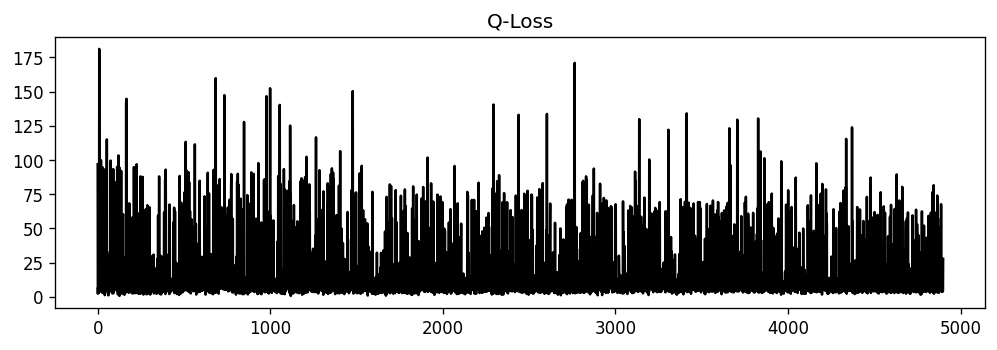

In [99]:
# Visualization of Q-loss

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(q_detached, color='black')
plt.title('Q-Loss')

Text(0.5, 1.0, 'Policy-Loss')

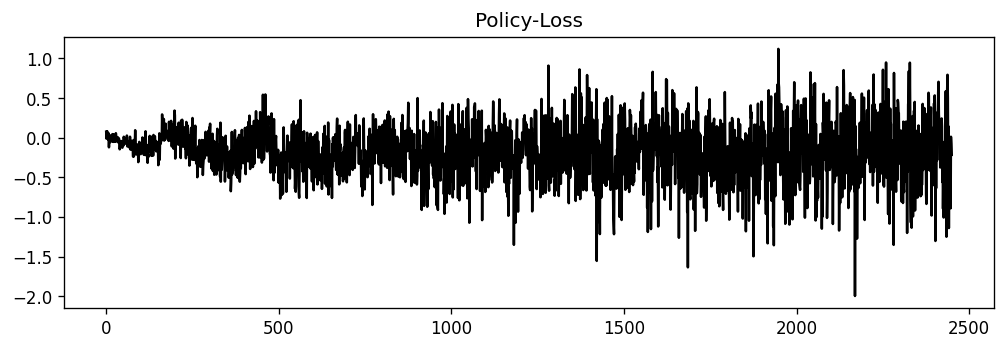

In [100]:
# Visualization of Policy-Loss

plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(policy_detached, color='black')
plt.title('Policy-Loss')

##### Performance Evaluation

In [101]:
def test_agent_net_worths(env, agent, num_test_episodes, max_ep_len):
    ep_rets, ep_lens = [], []
    for j in range(num_test_episodes):
        state, done, ep_ret, ep_len = env.reset(), False, 0, 0
        while not(done or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            state, reward, done, info = env.step(agent.get_action(state, 0))
            ep_ret += reward
            ep_len += 1
        ep_rets.append(ep_ret)
        ep_lens.append(ep_len)
    return np.mean(ep_rets), np.mean(ep_lens), info


### Training Environment

In [102]:
max_steps=len(X_train)
# performance(agent, train_env, max_steps, 1)
reward, ep_len, info = test_agent_net_worths(train_env, agent, 1, max_steps)
net_worths = [x[0][0] for x in info]

4521.1206
26264


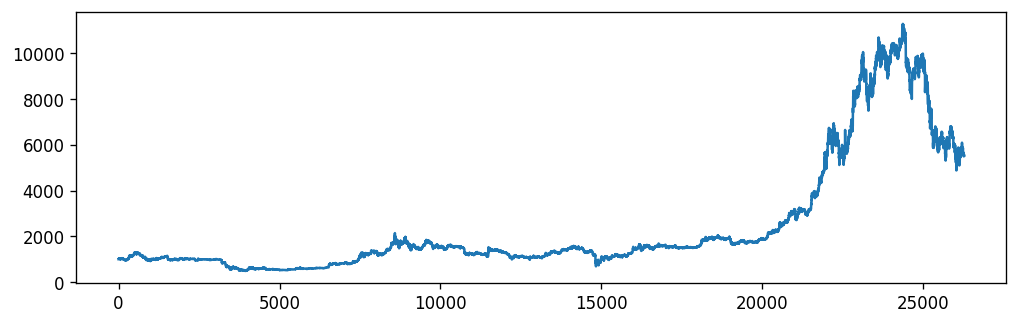

In [103]:
print(reward)
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(net_worths)
print(len(net_worths))

### Testing Environment

In [104]:
df=X_test
y=y_test
max_steps=len(df)
test_env = FinEnv(df, y)

reward, ep_len, info = test_agent_net_worths(test_env, agent, 1, max_steps)
net_worths = [x[0][0] for x in info]

401.4037
4368


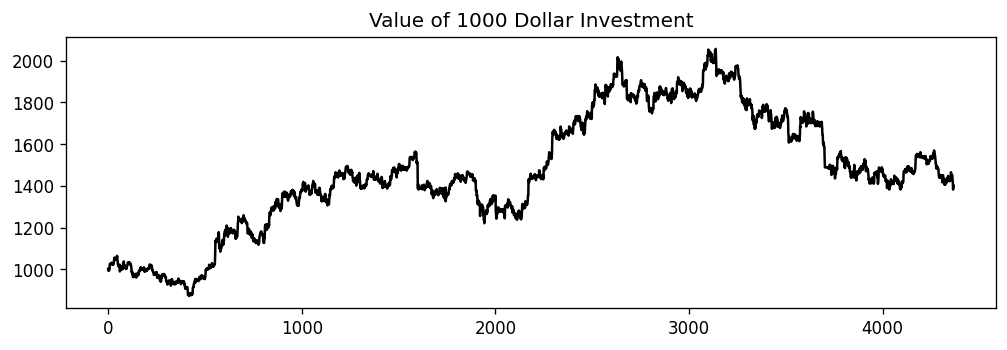

In [105]:
print(reward)
plt.rcParams.update({'figure.figsize':(10,3), 'figure.dpi':120})
plt.plot(net_worths, color='black')
plt.title('Value of 1000 Dollar Investment')
print(len(net_worths))

### Saving and Reloading the Agent

In [106]:
# torch.save(agent, 'Models/CNN T3D gamma_0.25 LTC.h5')

In [107]:
# agent = torch.load('Models/CNN T3D gamma_0.35 BTC.h5')
# agent.eval()

In [108]:
# # Models to evaluate

# models=['Models/CNN T3D gamma_0 b BTC.h5', 'Models/CNN T3D gamma_0.15 b BTC.h5', 'Models/CNN T3D gamma_0.25 b BTC.h5',
#        'Models/CNN T3D gamma_0.35 b BTC.h5', 'Models/CNN T3D gamma_0.5 b BTC.h5', 'Models/CNN T3D gamma_0.75 b BTC.h5',
#        'Models/CNN T3D gamma_0.8 b BTC.h5', 'Models/CNN T3D gamma_0.9 b BTC.h5', 'Models/CNN T3D gamma_0.95 b BTC.h5',
#        'Models/CNN T3D gamma_1 b BTC.h5']

In [109]:
# # Evaluating our models

# for model in models:
#     print(model)
#     agent = torch.load(model)
#     df=X_test
#     y=y_test
#     max_length=len(df)
#     test_env = FinEnv(df, y)

#     n_games=10
#     t_max=max_length

#     reward, ep_len, info = test_agent_net_worths(test_env, agent, n_games, t_max)
    
#     print('Average Rewards after',t_max, 'steps in',n_games, 'game(s) is:', reward)
#     print('\n')


We see the best $\gamma=0.25,0.5$